# Phase 4: Graph Visualization (HDFS Version)
This notebook visualizes the book communities detected in Phase 3.

In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, collect_list, struct

# Configurable Limit for Visualization
TOP_COMMUNITIES = 10
NODES_PER_COMMUNITY = 50 # Increase sample size since we are looking at only 1 community
MAX_BOOKS_PER_USER_FILTER = 500 # Filter out noisy heavy readers

In [ ]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("Goodreads_Graph_Vis") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

print("✅ Spark Session created.")

In [ ]:
# HDFS Paths
hdfs_base = "hdfs:///user/ubuntu/goodreads_data/processed"
communities_path = f"{hdfs_base}/book_communities"
books_path = f"{hdfs_base}/master_books" # Need books metadata for titles
interactions_path = f"{hdfs_base}/master_interactions"

In [ ]:
# Load Communities
print("⏳ Reading communities...")
try:
    df_communities = spark.read.parquet(communities_path)
    print(f"✅ Communities loaded. Rows: {df_communities.count()}
    df_communities.printSchema()
except Exception as e:
    print(f"❌ Communities file not found: {e}")

# Load Books Metadata (for Titles)
print("⏳ Reading books metadata...")
try:
    df_books = spark.read.json(f"hdfs:///user/ubuntu/goodreads_books.json.gz").select("book_id", "title", "title_without_series")
    # Note: Using raw books for titles if master_books doesn't exist or has different schema
    print("✅ Books metadata loaded.")
except Exception as e:
    print(f"❌ Books file not found: {e}")

# Load Interactions & Filter for Community Popularity
print("⏳ Reading interactions...")
try:
    df_interactions = spark.read.parquet(interactions_path)
    
    # Filter heavy users (same logic as Graph Construction)
    user_counts = df_interactions.groupBy("user_id").count()
    valid_users = user_counts.filter(col("count") <= MAX_BOOKS_PER_USER_FILTER).select("user_id")
    
    df_filtered_interactions = df_interactions.join(valid_users, "user_id", "inner")
    
    # Count readers per book (Filtered / Local Popularity)
    df_book_counts = df_filtered_interactions.groupBy("book_id").count().withColumnRenamed("count", "read_count")
    print("✅ Interactions filtered (heavy users removed) and aggregated.")
except Exception as e:
    print(f"❌ Interactions file not found: {e}")

In [ ]:
# Join Communities with Titles AND Popularity
df_communities = df_communities.withColumnRenamed("id", "book_id")

# 1. Join with Titles
df_enriched = df_communities.join(df_books, "book_id")

# 2. Join with Read Counts (Popularity)
df_enriched = df_enriched.join(df_book_counts, "book_id", "left").fillna(0, subset=["read_count"])

# Find Top Communities
top_communities = df_enriched.groupBy("component").count().orderBy(desc("count")).limit(TOP_COMMUNITIES)
top_ids = [row["component"] for row in top_communities.collect()]
print(f"🔹 Top {TOP_COMMUNITIES} Communities by size: {top_ids}")

# Filter Data for Visualization
# FOCUS ON TOP 1 COMMUNITY ONLY per user request
if top_ids:
    top_1_id = top_ids[0]
    print(f"🔹 Focusing Visualization on Top 1 Community Only (ID: {top_1_id})")
    df_vis = df_enriched.filter(col("component") == top_1_id)
else:
    df_vis = df_enriched.filter(col("component").isin(top_ids))

# Collect samples for Gephi/NetworkX
# We rankings books by POPULARITY (read_count) now, not just ID
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# RANK BY READ COUNT (Most popular books first)
windowSpec = Window.partitionBy("component").orderBy(desc("read_count")) 

df_sample = df_vis.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= NODES_PER_COMMUNITY)

pdf_sample = df_sample.toPandas()
print(f"🔹 Sample Data for Vis: {len(pdf_sample)} rows")
print(pdf_sample[['title', 'read_count', 'rank']].head())

# Save Top 1 Community to Local CSV for Inspection
if top_ids:
    top_comm_id = top_ids[0]
    print(f"🔹 Extracting books for Top Community ID: {top_comm_id}")
    
    # Order export by read_count too
    df_top1 = df_enriched.filter(col("component") == top_comm_id) \
        .select("book_id", "title", "read_count", "component") \
        .orderBy(desc("read_count"))
    
    count_top1 = df_top1.count()
    print(f"🔹 Found {count_top1} books in Community {top_comm_id}")
    
    if count_top1 > 0:
        df_top1.toPandas().to_csv("top_community_books.csv", index=False)
        print(f"💾 Saved {count_top1} books from Community {top_comm_id} to 'top_community_books.csv'")
        print("Preview of exported books (Top Popular):")
        df_top1.show(5, truncate=False)
    else:
        print("⚠️ Warning: Top community has 0 books after filtering (check metadata joining).")

⏳ Computing edges for the sample visualization...


✅ Edges found: 300
💾 Saved graph image to 'top_community_graph.png'


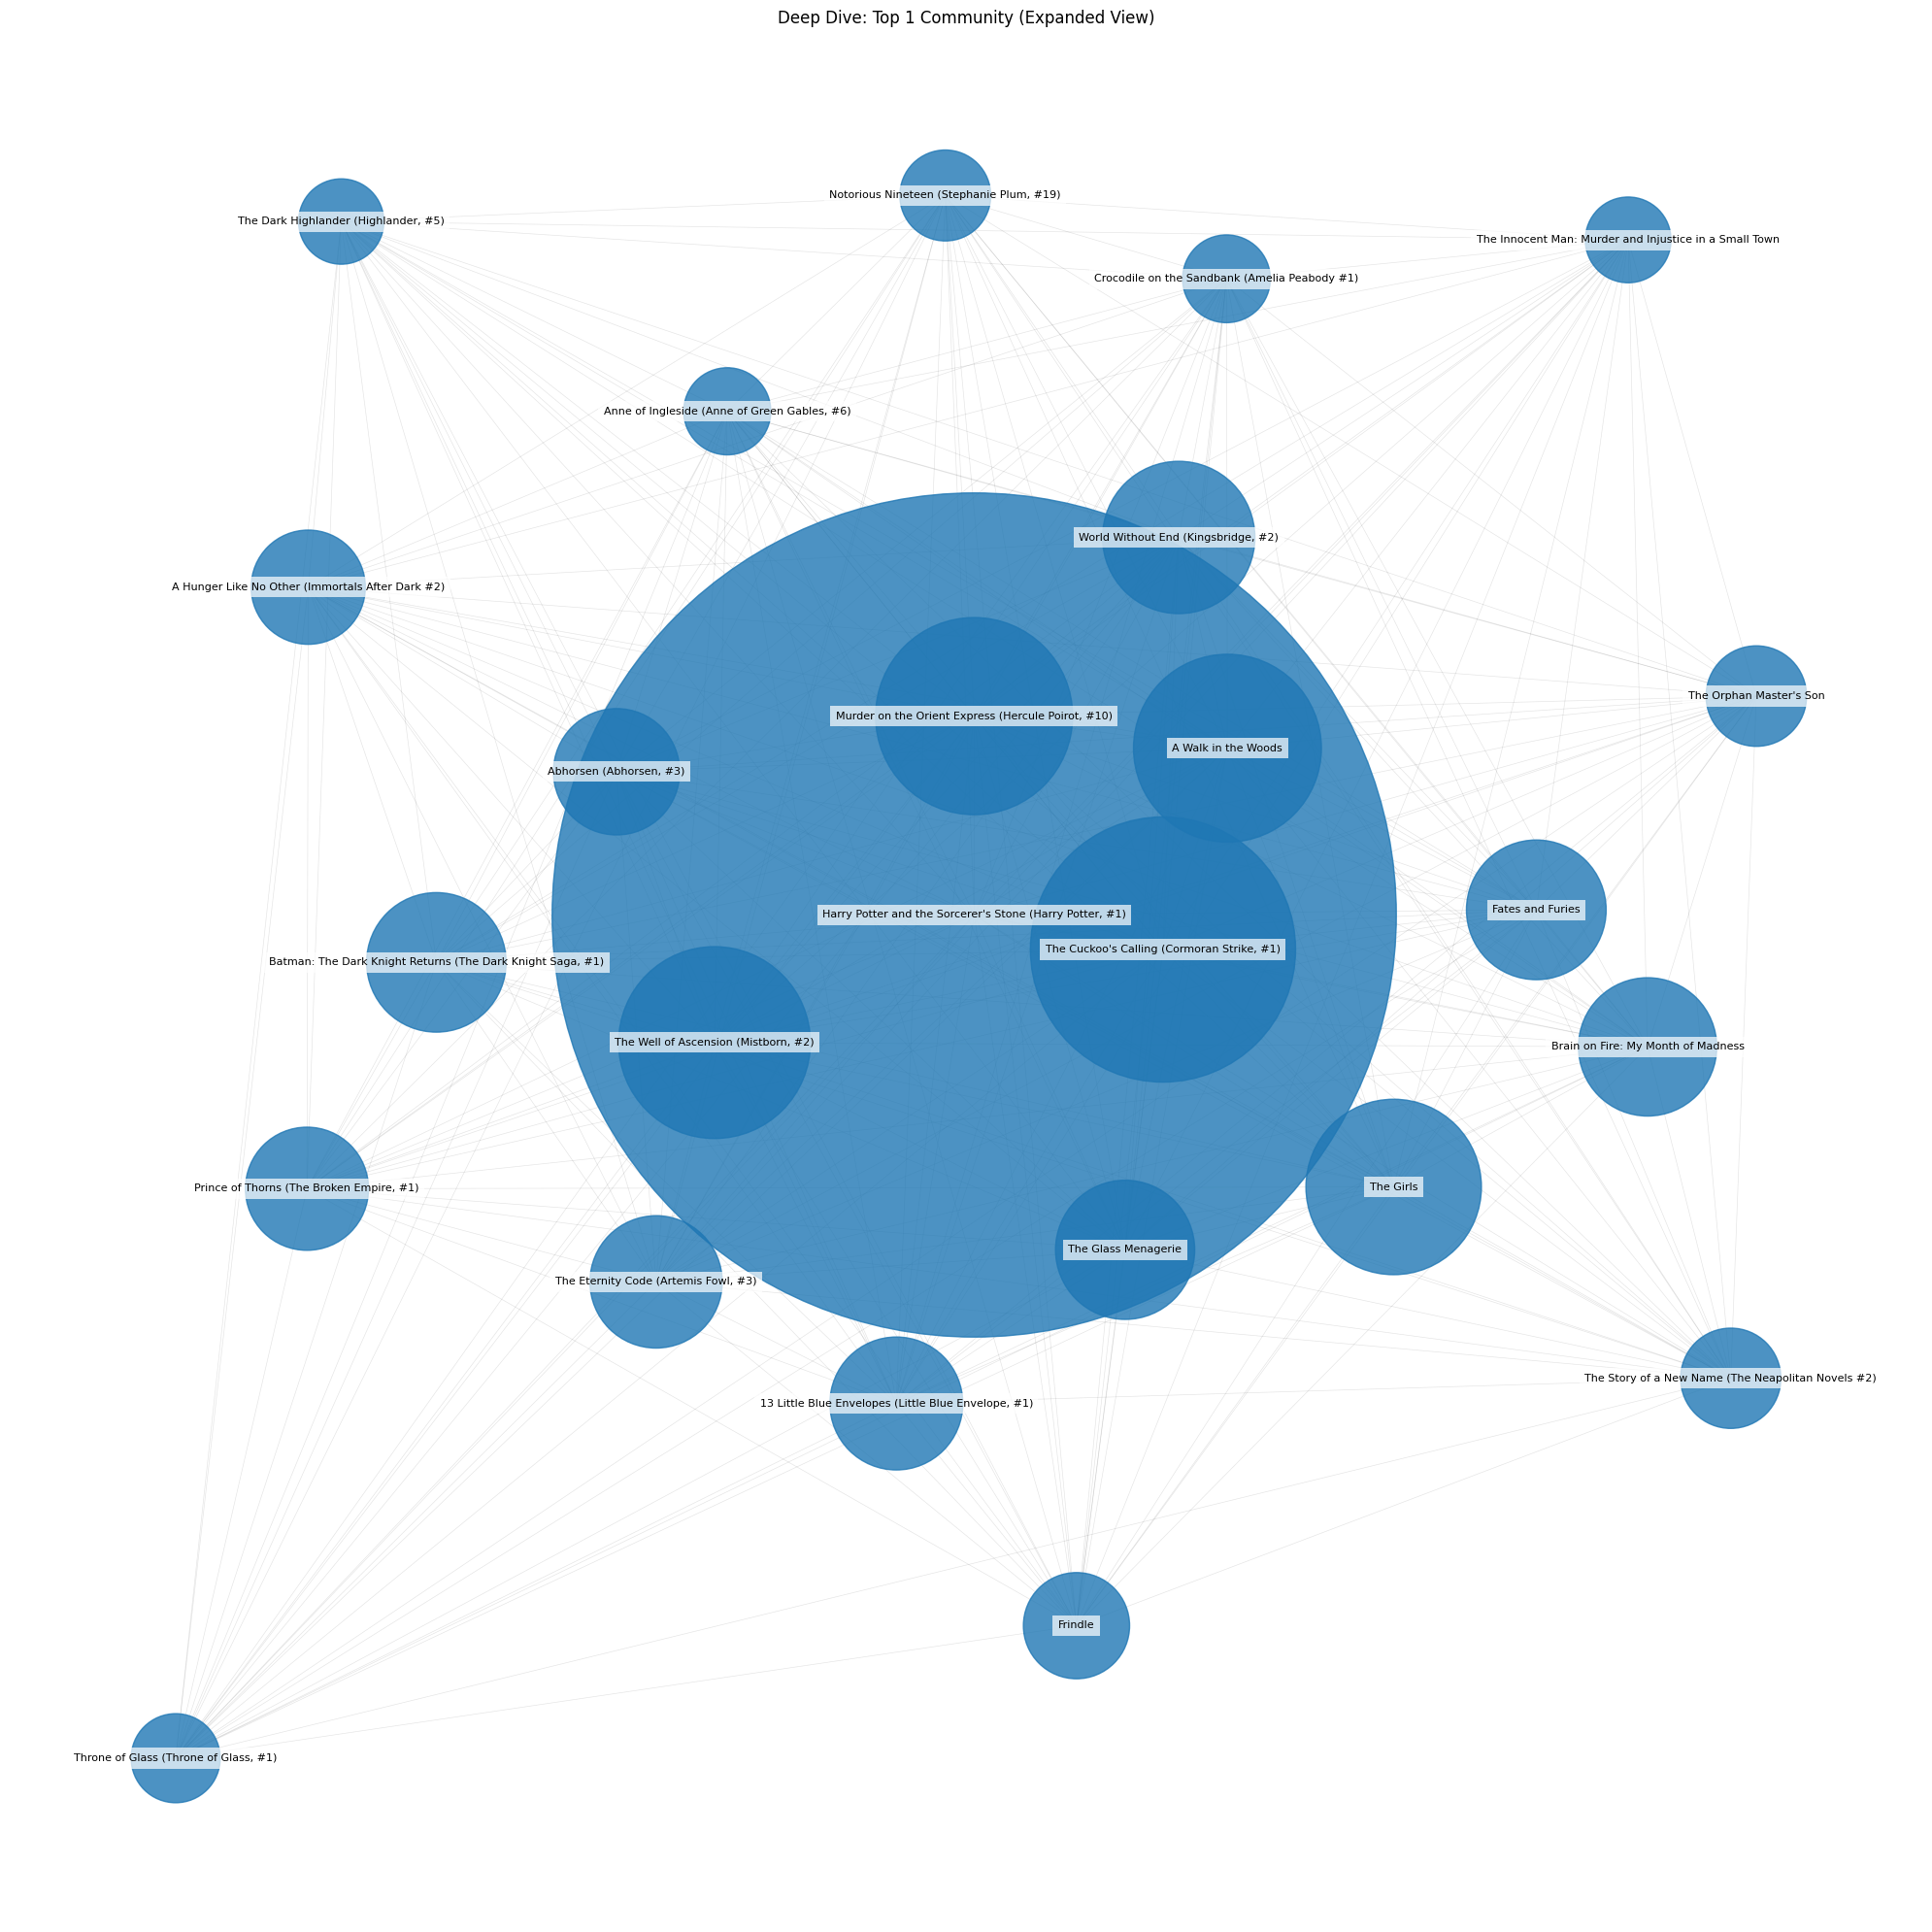

💾 Exported graph to book_communities.gexf


In [7]:
# Visualization using NetworkX
if not pdf_sample.empty:
    G = nx.Graph()
    
    # Add nodes
    for _, row in pdf_sample.iterrows():
        G.add_node(row['book_id'], title=row['title'], group=row['component'], popularity=row['read_count'])

    # COMPUTE EDGES FOR SAMPLE (Improve Cluster View)
    print("⏳ Computing edges for the sample visualization...")
    sample_book_ids = [row['book_id'] for _, row in pdf_sample.iterrows()]
    
    # Read interactions for these books only
    df_int = spark.read.parquet(interactions_path).select("user_id", "book_id")
    df_int_sample = df_int.filter(col("book_id").isin(sample_book_ids))
    
    # Self-join to find edges (who read both books)
    df_edges_sample = df_int_sample.alias("a").join(df_int_sample.alias("b"), "user_id") \
        .filter(col("a.book_id") < col("b.book_id")) \
        .groupBy(col("a.book_id").alias("src"), col("b.book_id").alias("dst")) \
        .count().withColumnRenamed("count", "weight")
        
    pdf_edges = df_edges_sample.toPandas()
    print(f"✅ Edges found: {len(pdf_edges)}")
    
    # Add edges to Graph
    for _, row in pdf_edges.iterrows():
        G.add_edge(row['src'], row['dst'], weight=row['weight'])

    # Drawing
    plt.figure(figsize=(20, 20))
    
    # Use Spring Layout with 'k' parameter to force nodes apart (Spreading them out)
    # k = 1.5 => connected nodes are pushed apart more
    pos = nx.spring_layout(G, k=0.3, iterations=100, seed=42)
    
    # Dynamic Node Size based on Popularity (Read Count) - Simple Scaling Request
    node_sizes = [G.nodes[n]['popularity'] * 1.5 for n in G.nodes()] # Scale factor 1.5
    
    # Fallback size if all are 0 or very small
    if sum(node_sizes) == 0: 
        node_sizes = 200
    
    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=pdf_sample['component'].astype(int), cmap=plt.cm.tab20, alpha=0.8)
    
    # Edges (Very thin and transparent)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
    
    # Labels (only if not too many)
    if len(G.nodes) < 150:
        labels = {row['book_id']: row['title'] for _, row in pdf_sample.iterrows()}
        # Draw labels with box and smaller font
        nx.draw_networkx_labels(G, pos, labels, font_size=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.title("Deep Dive: Top 1 Community (Expanded View)")
    plt.axis('off')
    plt.tight_layout()
    
    # Save the plot as an image
    plt.savefig("top_community_graph.png", dpi=300, bbox_inches='tight')
    print("💾 Saved graph image to 'top_community_graph.png'")
    
    plt.show()
    
    # Export to GEXF for Gephi (Better for large graphs)
    nx.write_gexf(G, "book_communities.gexf")
    print("💾 Exported graph to book_communities.gexf")